In [11]:
import pandas as pd
import os.path

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

import altair as alt

# Show an image where the interactive plot is not supported such as on gradescope
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server') 

DataTransformerRegistry.enable('data_server')

# Project: Box Office Predictions
## Exploratory Data Analysis

Here is the URL of our data source:

https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset/download


In [12]:
#url = "https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset/download"
local_path = "data/raw/IMDb movies.csv"

## Read local file if already exists, otherwise read from URL.
try:
    movies_raw = pd.read_csv(local_path)
except:
    print("Please ensure that {local_path} is available.")
movies_raw.info()

Please ensure that {local_path} is available.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          85855 non-null  object 
 1   title                  85855 non-null  object 
 2   original_title         85855 non-null  object 
 3   year                   85855 non-null  object 
 4   date_published         85855 non-null  object 
 5   genre                  85855 non-null  object 
 6   duration               85855 non-null  int64  
 7   country                85791 non-null  object 
 8   language               85022 non-null  object 
 9   director               85768 non-null  object 
 10  writer                 84283 non-null  object 
 11  production_company     81400 non-null  object 
 12  actors                 85786 non-null  object 
 13  description            83740 non-null  object 
 14  avg_vote

### Points to note:

- There are 85855 rows of data and 22 columns.
- Some columns (e.g. budget) have a lot of missing values.

Let us read some sample rows:

In [3]:
movies_raw.sample(5)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
25563,tt0100541,Sale comme un ange,Sale comme un ange,1991,1991-06-19,"Drama, Romance",102,France,French,Catherine Breillat,...,"Claude Brasseur, Lio, Nils Tavernier, Roland A...","A middle-aged tough cop, Georges Deblache, is ...",5.8,232,NaN,NaN,NaN,NaN,NaN,2.0
74480,tt4369136,Hide in the Light,Hide in the Light,2018,2018-10-23,"Horror, Thriller",78,USA,English,Mikey McGregor,...,"Eric Roberts, Jesse James, Clayton Snyder, Dav...",An adventurous group of friends dare to break ...,3.8,335,NaN,NaN,NaN,NaN,15.0,4.0
74714,tt4450706,Parla con tuo marito,Kocan Kadar Konus,2015,2015-03-20,"Comedy, Drama, Fantasy",108,Turkey,Turkish,Kivanç Baruönü,...,"Bora Akkas, Gül Arici, Enis Arikan, Sebnem Bur...",A traditional Turkish woman tries to find love...,6.2,4448,NaN,NaN,$ 8674655,NaN,6.0,3.0
9149,tt0050544,Interludio,Interlude,1957,1957-10-30,"Drama, Romance",90,USA,English,Douglas Sirk,...,"June Allyson, Rossano Brazzi, Marianne Koch, F...","The story of a young woman, Helen Banning, who...",6.3,388,NaN,NaN,NaN,NaN,10.0,12.0
50327,tt0819792,Onni von Sopanen,Onni von Sopanen,2006,2006-08-11,Family,90,Finland,Finnish,Johanna Vuoksenmaa,...,"Kaarlo Somerto, Julius Vakkuri, Alex Anton, Oo...",NaN,6.5,128,EUR 200000,NaN,NaN,NaN,NaN,1.0


Since we may use the column `worlwide_gross_income` as the target, while full pre-processing will be done at a later stage, let us remove all the rows of the following conditions:
1. with missing values in that column; and
2. with non-USD currencies in that column.
And then we convert the column to numeric.

In [4]:
movies_df = movies_raw.dropna(subset=['worlwide_gross_income'])
movies_df = movies_df.loc[movies_df['worlwide_gross_income'].str.contains('\$')]
movies_df['worlwide_gross_income'] = movies_df['worlwide_gross_income'].str.replace('$', '').astype(int)
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30955 entries, 79 to 85854
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          30955 non-null  object 
 1   title                  30955 non-null  object 
 2   original_title         30955 non-null  object 
 3   year                   30955 non-null  object 
 4   date_published         30955 non-null  object 
 5   genre                  30955 non-null  object 
 6   duration               30955 non-null  int64  
 7   country                30940 non-null  object 
 8   language               30801 non-null  object 
 9   director               30935 non-null  object 
 10  writer                 30537 non-null  object 
 11  production_company     30044 non-null  object 
 12  actors                 30931 non-null  object 
 13  description            30209 non-null  object 
 14  avg_vote               30955 non-null  float64
 15  v

/var/folders/g8/45jnc14159517h27k04t6w_h0000gq/T/ipykernel_87602/2480873827.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies_df['worlwide_gross_income'] = movies_df['worlwide_gross_income'].str.replace('$', '').astype(int)


Now we split the data so that we are compliant with the **Golden Rule**.  The subsequent EDA will be done on the train data set ONLY.

In [5]:
train_df, test_df = train_test_split(movies_df, test_size=0.25, random_state=2021)
print("Shape of train data set: ", train_df.shape)
print("Shape of test data set: ", test_df.shape)

Shape of train data set:  (23216, 22)
Shape of test data set:  (7739, 22)


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23216 entries, 24548 to 75785
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          23216 non-null  object 
 1   title                  23216 non-null  object 
 2   original_title         23216 non-null  object 
 3   year                   23216 non-null  object 
 4   date_published         23216 non-null  object 
 5   genre                  23216 non-null  object 
 6   duration               23216 non-null  int64  
 7   country                23203 non-null  object 
 8   language               23100 non-null  object 
 9   director               23201 non-null  object 
 10  writer                 22894 non-null  object 
 11  production_company     22544 non-null  object 
 12  actors                 23197 non-null  object 
 13  description            22645 non-null  object 
 14  avg_vote               23216 non-null  float64
 15

In [7]:
train_df.describe()

,duration,avg_vote,votes,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
count,23216.000000,23216.000000,2.321600e+04,2.321600e+04,8459.000000,21425.000000,21834.000000
mean,105.194004,6.091316,2.455595e+04,2.221960e+07,56.111361,96.846954,52.100760
std,20.708951,1.097460,8.815613e+04,8.645474e+07,17.740327,282.453411,84.130592
min,45.000000,1.000000,1.000000e+02,1.000000e+00,1.000000,1.000000,1.000000
25%,92.000000,5.500000,4.420000e+02,1.137130e+05,44.000000,4.000000,6.000000
50%,101.000000,6.200000,1.646000e+03,1.113050e+06,57.000000,18.000000,19.000000
75%,114.000000,6.800000,9.688000e+03,8.113566e+06,69.000000,76.000000,60.000000
max,808.000000,9.300000,2.278845e+06,2.797801e+09,100.000000,10472.000000,999.000000


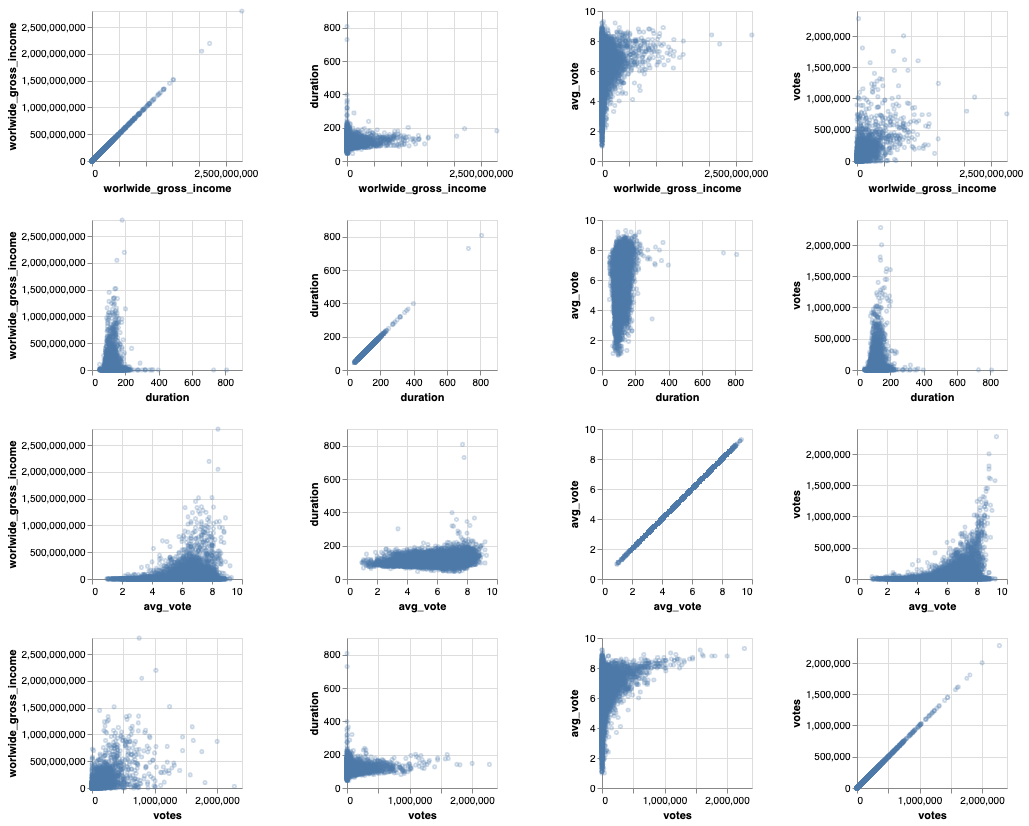

In [8]:
numeric_cols_names_1 = ['worlwide_gross_income', 
                      'duration', 
                      'avg_vote', 
                      'votes']
numeric_cols_names_2 = ['worlwide_gross_income', 
                        'metascore', 
                        'reviews_from_users', 
                        'reviews_from_critics']

numeric_cols_plot_1 = alt.Chart(train_df).mark_point(opacity=0.3, size=10).encode(
     alt.X(alt.repeat('row'), type='quantitative'),
     alt.Y(alt.repeat('column'), type='quantitative')
).properties(
    width=150,
    height=150
).repeat(
    column=numeric_cols_names_1,
    row=numeric_cols_names_1
)

numeric_cols_plot_1

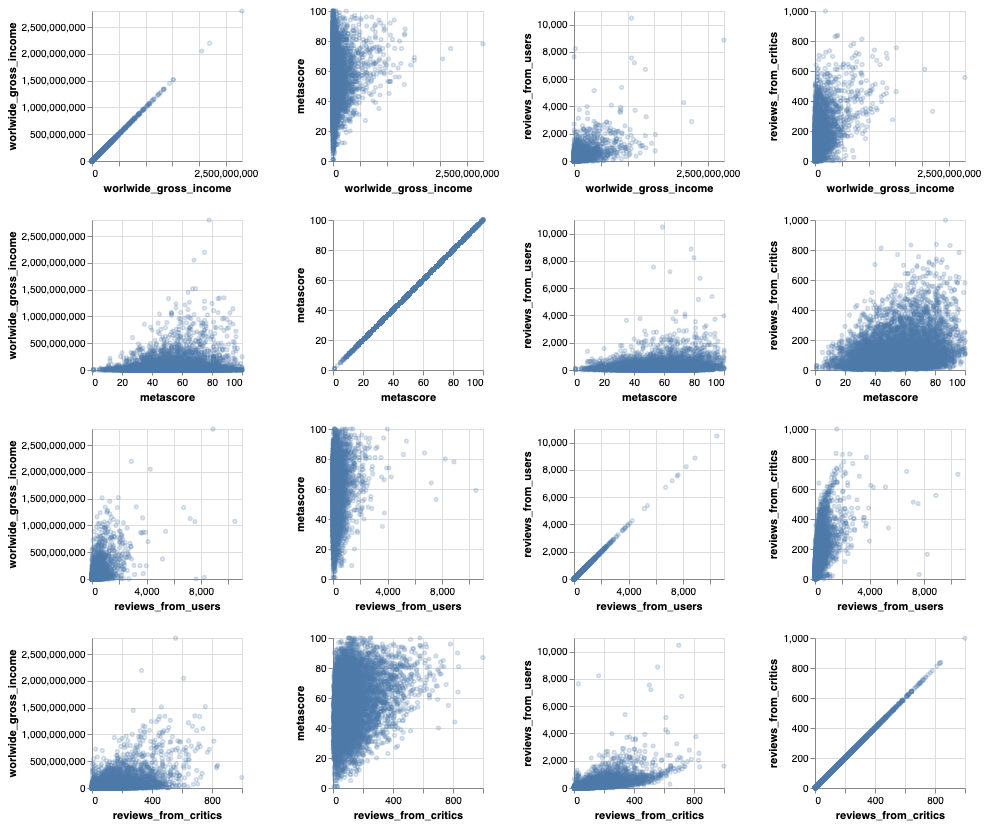

In [9]:
numeric_cols_plot_2 = alt.Chart(train_df).mark_point(opacity=0.3, size=10).encode(
     alt.X(alt.repeat('row'), type='quantitative'),
     alt.Y(alt.repeat('column'), type='quantitative')
).properties(
    width=150,
    height=150
).repeat(
    column=numeric_cols_names_2,
    row=numeric_cols_names_2
)
numeric_cols_plot_2

We can roughly see that:

1. Certain durations (which like around the center of its distribution) have the highest worldwide gross income; 
2. Average vote is positively correlated with worldwide gross income; 
3. Metascore seems to correlate with worldwide gross income positively but not strongly; and
4. Reviews from users seem to correlate more prominently with worldwide gross income compared to reviews from critics.

Now let's plot some histograms on the categorical columns:

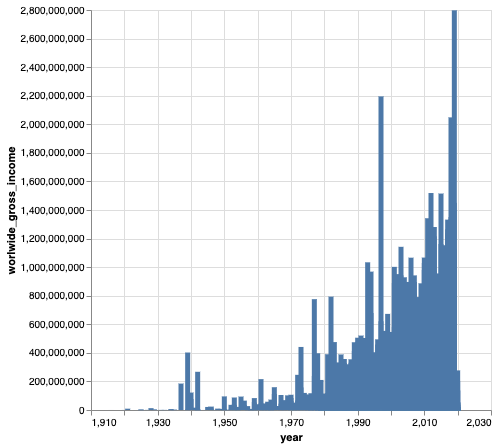

In [10]:
year_plot = alt.Chart(train_df).mark_bar().encode(
    alt.Y('worlwide_gross_income', type='quantitative'),
    x='year',
    tooltip=['title', 'year', 'worlwide_gross_income']
).properties(
    height=400
)

year_plot

Regarding the relationship between year and worldwide gross income:

1. There is a positive correlation (probably inflation); but
2. There are also a few exceptions, one being Titanic in 1997, the record of which would only be broken 22 years later.

Many columns, e.g. language, genre, country have multiple categories in one value and they need additional wrangling before further analysis which is beyond the scope of this EDA.